In [4]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
pd.DataFrame(np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/1kg/ctrl.397.cov", dtype=object))

,0,1,2,3,4,5,6,7,8,9,...,389,390,391,392,393,394,395,396,397,398
0,0,HG00096,36.4011,35.8928,36.2514,37.3474,42.441,34.9266,35.8208,31.8176,...,31.8752,33.9546,31.7841,37.0888,36.8578,33.5221,33.1757,35.8835,38.8129,40.3303
1,1,HG00097,37.3755,35.622,33.7913,39.0321,42.264,35.0289,34.6869,32.3021,...,34.1973,32.8303,31.7952,35.8454,33.2859,34.8707,35.4051,35.9232,33.9526,36.6692
2,2,HG00099,42.4412,41.5983,42.2358,42.5739,45.383,39.8675,41.2145,37.5186,...,37.3149,35.9088,40.166,43.2713,38.7448,41.2271,38.8703,38.0216,42.6089,43.3908
3,3,HG00100,33.1409,32.5443,36.1569,36.599,37.7148,32.3273,32.5497,28.7945,...,32.4557,30.1537,30.7199,34.4752,34.9404,35.7668,31.7962,32.2974,34.4421,39.4986
4,4,HG00101,34.3042,37.3873,37.2131,36.9663,43.4903,31.0541,37.1798,35.1009,...,34.986,33.5329,32.4282,35.1362,35.8847,34.0347,34.2627,35.116,37.3695,39.5721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2488,2499,NA21137,33.6384,32.0336,34.727,34.8212,38.4946,32.4299,31.7902,29.3066,...,31.6828,33.4093,32.3933,36.4835,35.354,33.8825,34.4182,31.1463,32.0841,38.1808
2489,2500,NA21141,36.7817,35.9291,40.1793,41.0853,44.8629,36.1905,39.6977,33.8221,...,33.6354,34.9772,34.7229,35.8801,38.2912,38.4366,39.2318,33.6586,37.2024,42.8508
2490,2501,NA21142,40.0774,44.4787,37.8291,41.1627,44.2251,40.8193,40.3771,36.7607,...,38.2179,38.6591,38.9152,41.4221,38.6645,39.8951,37.7453,39.648,38.817,42.1587
2491,2502,NA21143,35.9976,39.6041,37.0816,41.5221,46.011,39.5581,38.3121,38.3261,...,42.1199,40.8615,41.3467,44.7317,42.6868,40.4127,45.3856,46.487,42.8537,44.894


In [30]:
pd.DataFrame(np.loadtxt("/home/cmb-17/mjc/vntr_genotyping/cmb-16/work/vntr/hapdb/a1_regions/ctrl/pan.fn2.bed", dtype=object))

,0,1,2
0,chr1,8012084,8015831
1,chr1,19150834,19154797
2,chr1,40236352,40240055
3,chr1,41579914,41584333
4,chr1,43995740,43999001
...,...,...,...
392,chr9,123791952,123795756
393,chr9,125842246,125845524
394,chr9,125909011,125913036
395,chr9,125962881,125966532


In [17]:
def NonparametricOutlierRemoval(x, k=1.5):
    """
    input will be flattened. Return: x_non_outlier, mask_non_outlier
    """
    q0, q1 = np.quantile(x, [0.25,0.75])
    kiqr = (q1 - q0) * k
    mask = np.logical_and(x >= q0 - kiqr, x <= q1 + kiqr)
    return x[mask], mask

In [27]:
def getLSB(covm, csize):
    """
    Return: LSB, mask_non_outlier_loci
    """
    ncov = covm / (covm @ csize / np.sum(csize))[:,None]
    ms = np.mean(ncov, axis=0)
    vs = np.var(ncov, axis=0)
    mask = np.logical_and(NonparametricOutlierRemoval(ms)[1], NonparametricOutlierRemoval(vs)[1])
    return ncov[:,mask], mask

explained variance [0.1356 0.0377]


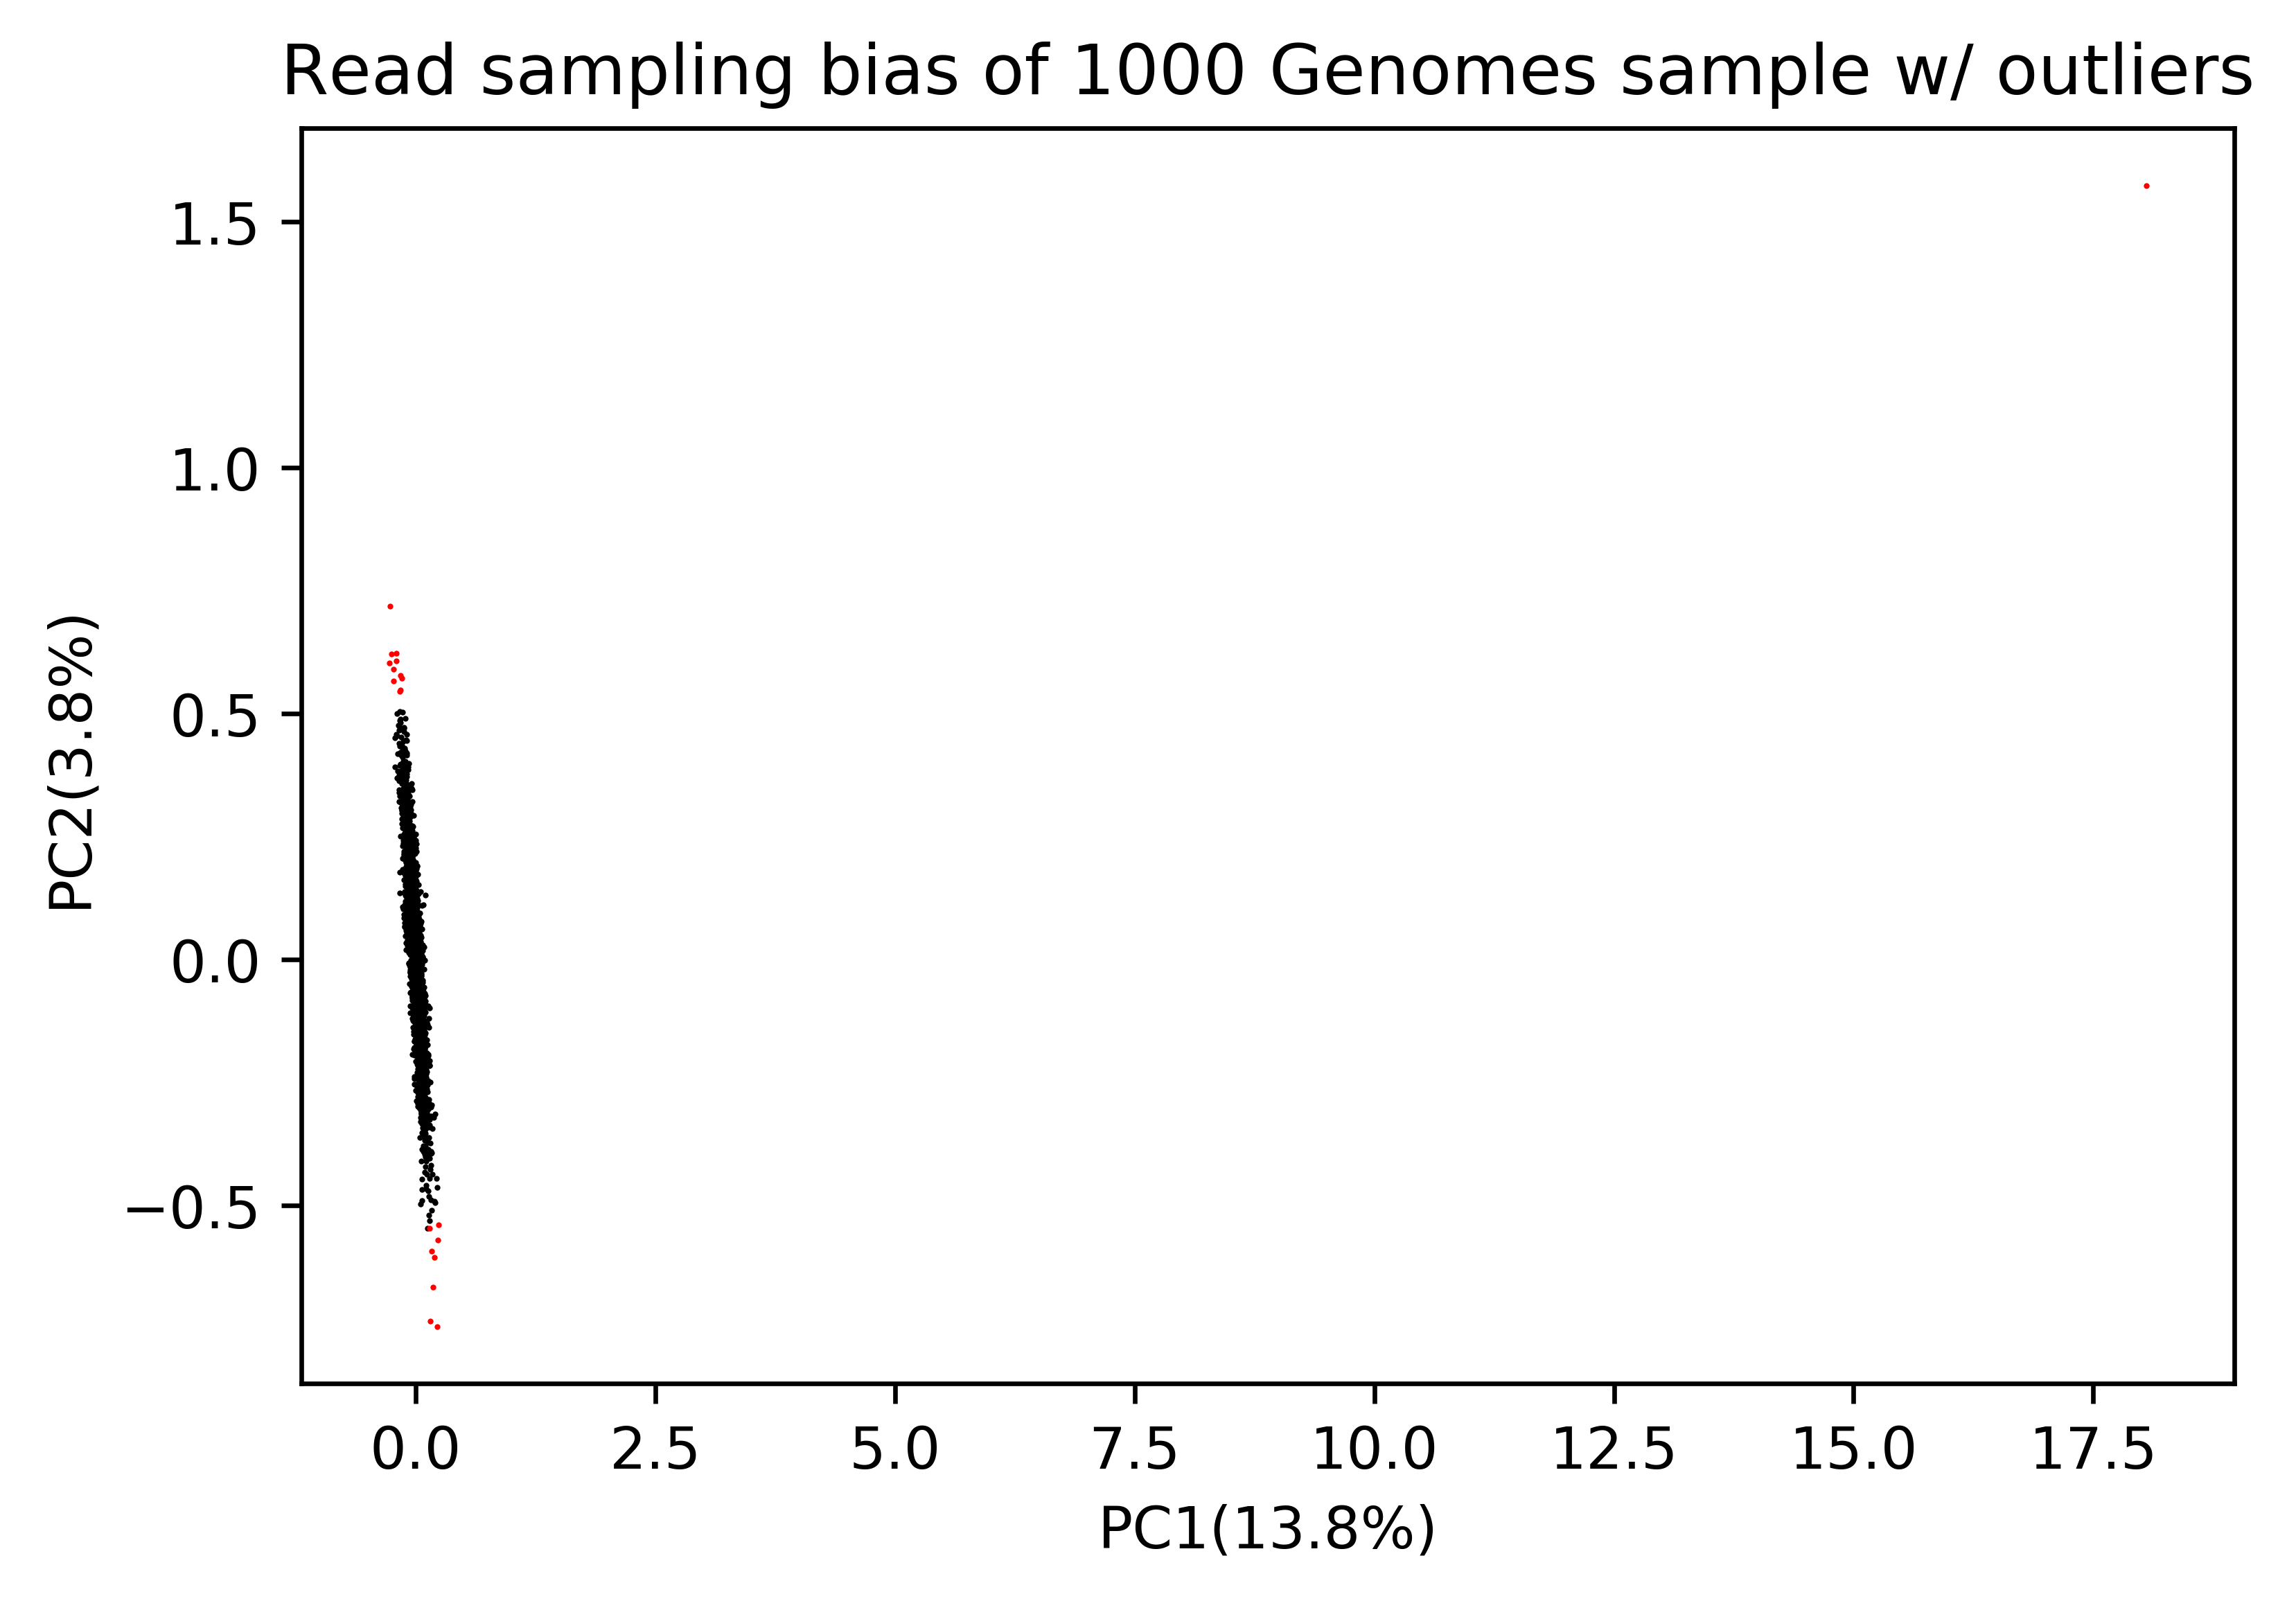

explained variance [0.0409 0.0281]


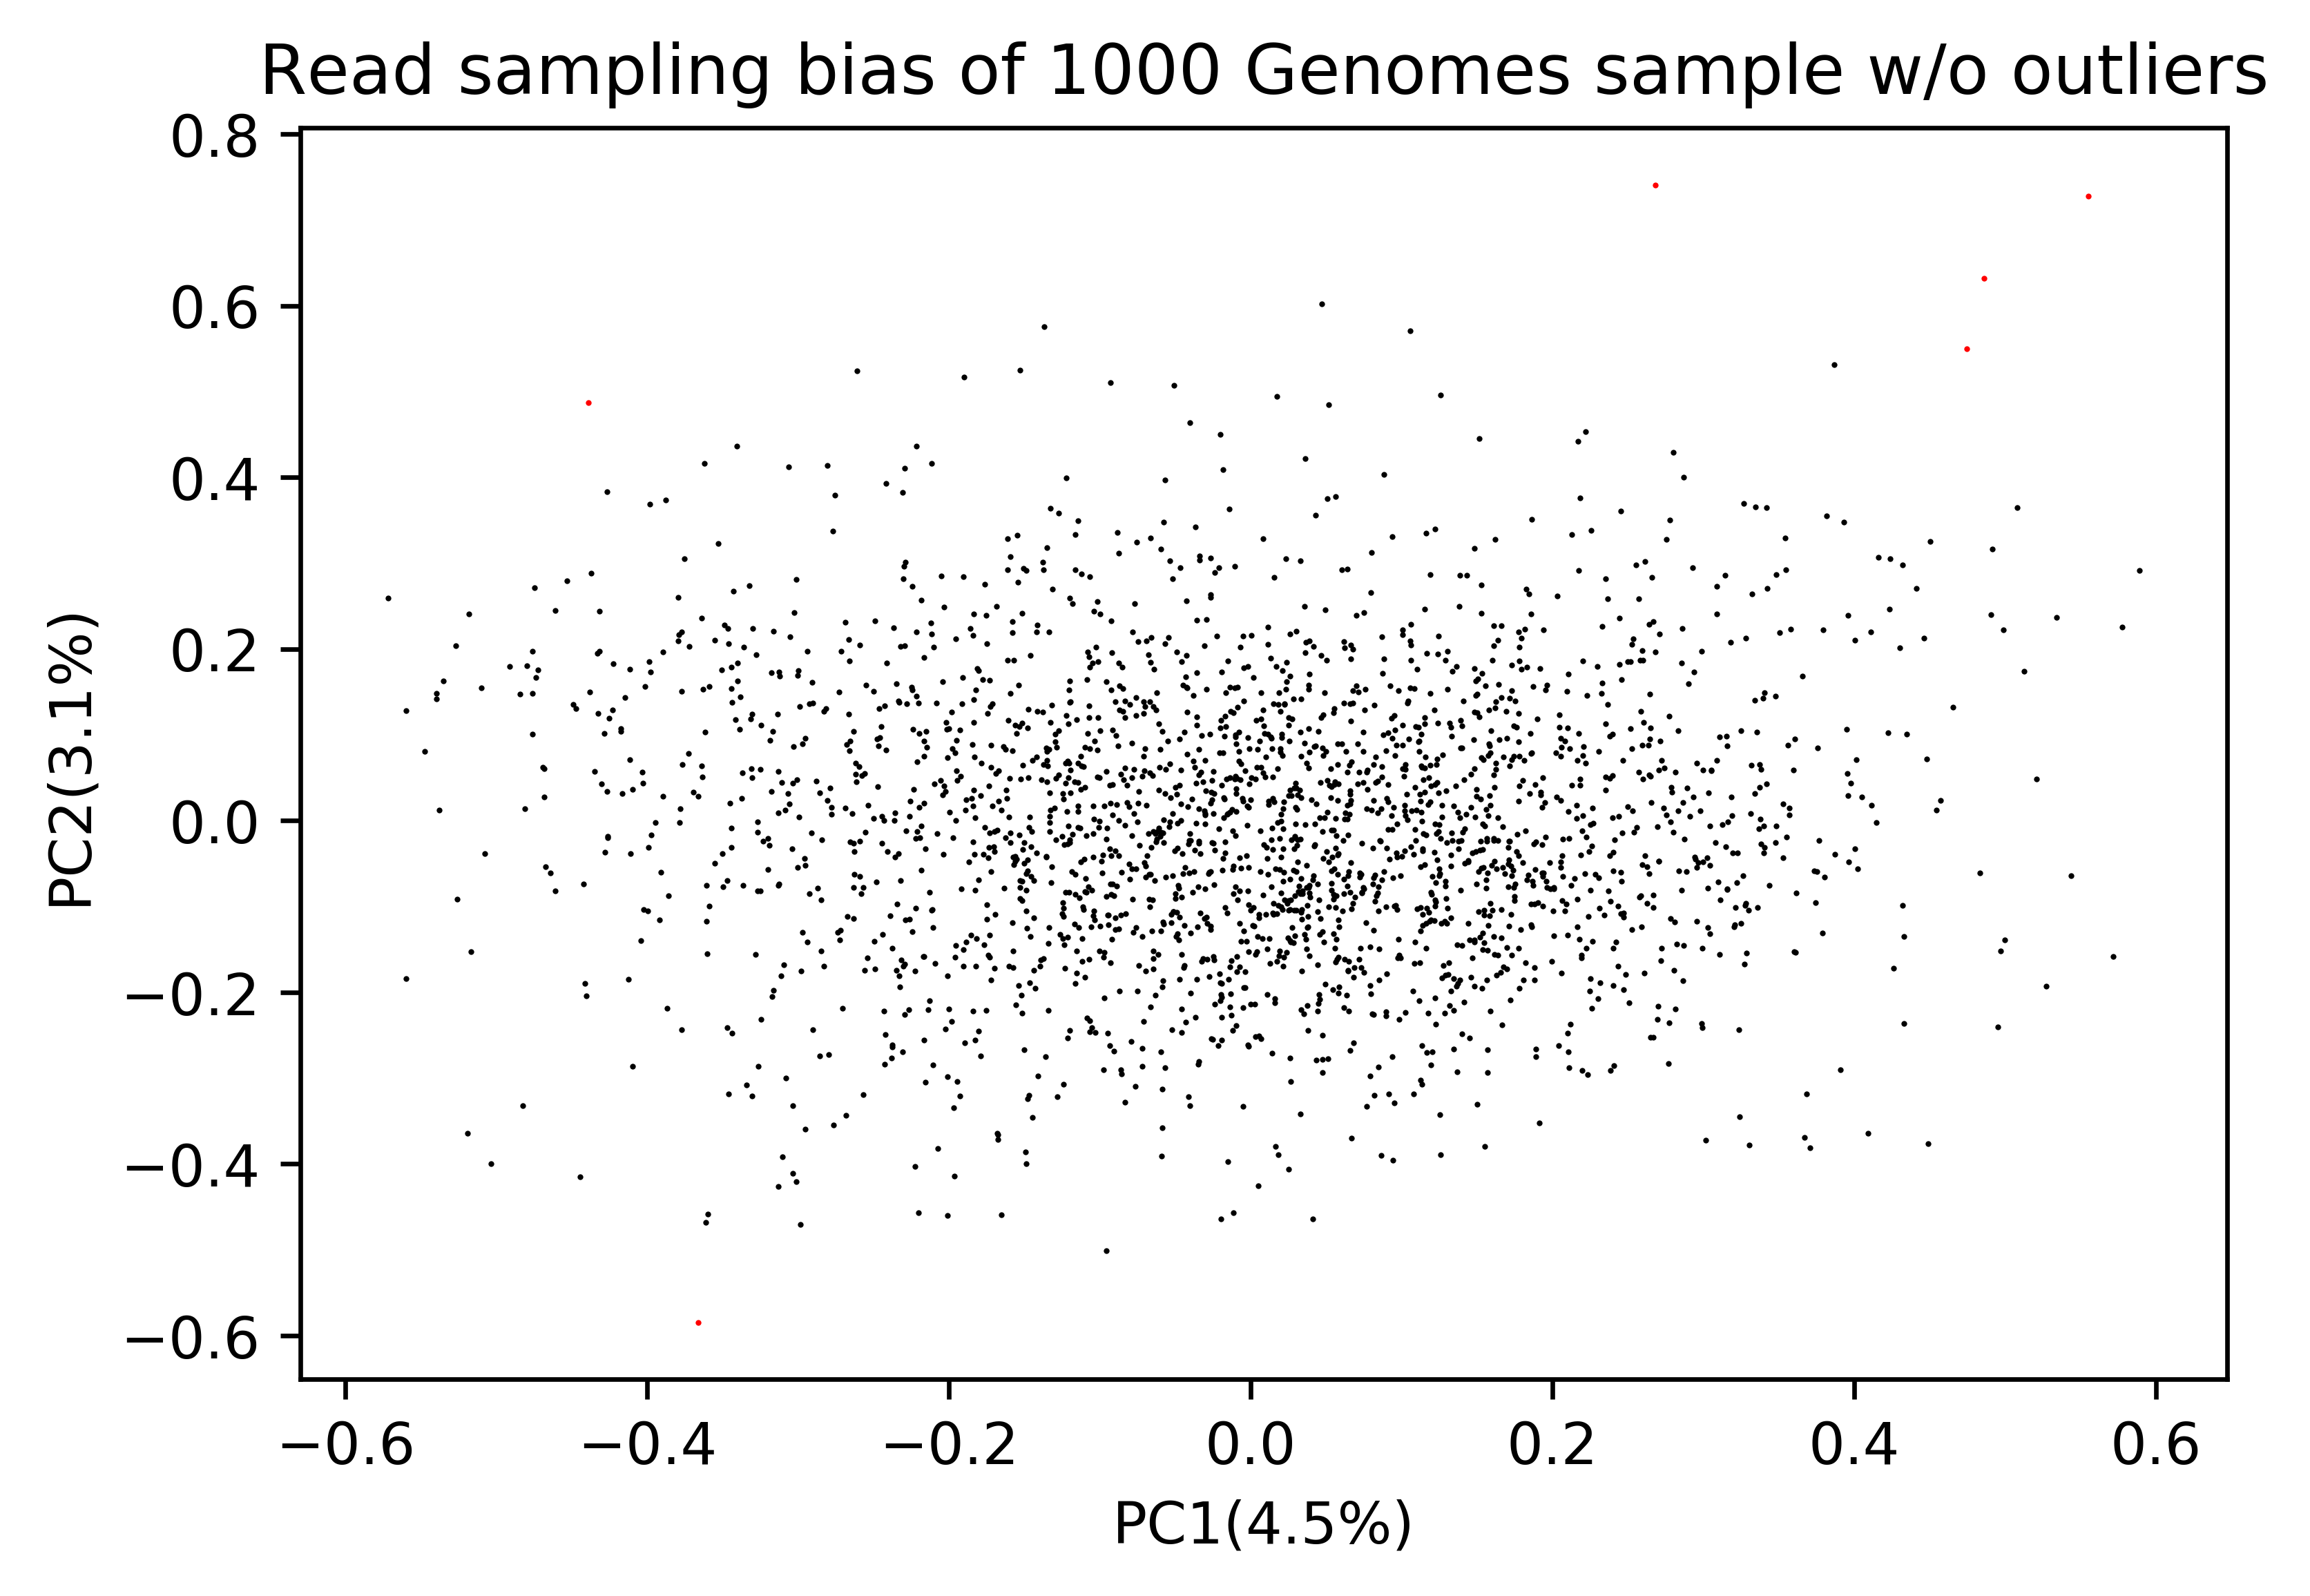

In [28]:
def test(covfile, ctrlbed):
    """
    covfile: output of script/getCovByLocus.397.sh
    ctrlbed: released under data/ctrl.bed
    """
    covmat = np.loadtxt(covfile, dtype=object)[:,1:]
    ctrlbed = np.loadtxt(ctrlbed, dtype=object)
    csize = ctrlbed[:,2].astype(int) - ctrlbed[:,1].astype(int)
    
    covm = covmat[:,1:].astype(float)
    LSB, Lm = getLSB(covm, csize)
    pca = PCA(n_components=2).fit(LSB)
    px = pca.transform(LSB)
    ev = pca.explained_variance_ratio_
    print("explained variance", pca.explained_variance_)
    
    d = np.linalg.norm(px - np.median(px, axis=0), axis=1) 
    dp, dm = NonparametricOutlierRemoval(d, k=2)

    plt.figure(dpi=600)
    plt.scatter(px[dm,0], px[dm,1], s=1, linewidths=0, c='k')
    plt.scatter(px[~dm,0], px[~dm,1], s=1, linewidths=0, c='r')
    plt.xlabel(f'PC1({ev[0]:.1%})')
    plt.ylabel(f'PC2({ev[1]:.1%})')
    plt.title("Read sampling bias of 1000 Genomes sample w/ outliers")
    plt.show(); plt.close()
    
    LSB, Lm = getLSB(covm[dm], csize)
    pca = PCA(n_components=2).fit(LSB)
    px = pca.transform(LSB)
    ev = pca.explained_variance_ratio_
    print("explained variance", pca.explained_variance_)
    
    d = np.linalg.norm(px - np.median(px, axis=0), axis=1) 
    dp, dm = NonparametricOutlierRemoval(d, k=2)

    plt.figure(dpi=600)
    plt.scatter(px[dm,0], px[dm,1], s=1, linewidths=0, c='k')
    plt.scatter(px[~dm,0], px[~dm,1], s=1, linewidths=0, c='r')
    plt.xlabel(f'PC1({ev[0]:.1%})')
    plt.ylabel(f'PC2({ev[1]:.1%})')
    plt.title("Read sampling bias of 1000 Genomes sample w/o outliers")
    plt.show(); plt.close()
        
    return

test("/home/cmb-17/mjc/vntr_genotyping/1kg/ctrl.397.cov", "/home/cmb-17/mjc/vntr_genotyping/cmb-16/work/vntr/hapdb/a1_regions/ctrl/pan.fn2.bed")